In [1]:
# Train, Evaluate and Save the DL Model


from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import numpy as np


batch_size = 128
num_classes = 10
epochs = 1

# input image dimensions
img_rows, img_cols = 28, 28

# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

if K.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

print('input_shape')
print(input_shape)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3),
                 activation='relu',
                 input_shape=input_shape))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))
model.save('my_model.h5')

# Save the weights
# model.save_weights('model_weights.h5')
# Save the model architecture
with open('model_architecture.json', 'w') as f:
    f.write(model.to_json())

score = model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])
print('M:')
print(y_test[0])
print(x_test[0].shape)
x = x_test[0].reshape(1, 28, 28, 1)
out = model.predict(x)
print(out[0])
print(np.argmax(out[0]))

/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


input_shape
(28, 28, 1)
x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples
Train on 60000 samples, validate on 10000 samples
Epoch 1/1
60000/60000 [==============================] - 113s 2ms/step - loss: 0.2644 - acc: 0.9192 - val_loss: 0.0590 - val_acc: 0.9806
Test loss: 0.05904419410275295
Test accuracy: 0.9806
M:
[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
(28, 28, 1)
[1.6856018e-07 2.6561606e-08 1.3166505e-06 4.8020115e-07 4.2803613e-08
 1.9657810e-10 4.7171815e-11 9.9999714e-01 5.6143367e-08 7.6083450e-07]
7


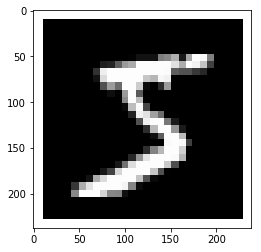

In [6]:
from keras.preprocessing.image import load_img
import matplotlib.pyplot as plt

img_normal = load_img('./last_image.png')
plt.imshow(img_normal)
plt.show()

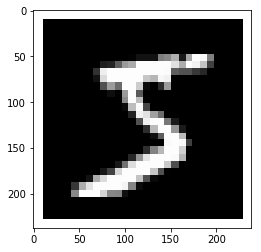

In [8]:
image_red = img_normal.resize((28, 28)).convert('1')
plt.imshow(img_normal)
plt.show()

In [5]:
# Make a flask API for our DL Model


from keras.preprocessing.image import img_to_array
from keras.models import load_model
from flask_restplus import Api, Resource, fields
from flask import Flask, request, jsonify
import numpy as np
from werkzeug.datastructures import FileStorage
from PIL import Image
from keras.models import model_from_json
import tensorflow as tf


app = Flask(__name__)
api = Api(app, version='1.0', title='MNIST Classification', description='CNN for Mnist')
ns = api.namespace('Make_School', description='Methods')

single_parser = api.parser()
single_parser.add_argument('file', location='files',
                           type=FileStorage, required=True)

model = load_model('my_model.h5')
graph = tf.get_default_graph()

# Model reconstruction from JSON file
# with open('model_architecture.json', 'r') as f:
#     model = model_from_json(f.read())
#
# # Load weights into the new model
# model.load_weights('model_weights.h5')


@ns.route('/prediction')
class CNNPrediction(Resource):
    """Uploads your data to the CNN"""
    @api.doc(parser=single_parser, description='Upload an mnist image')
    def post(self):
        args = single_parser.parse_args()
        image_file = args.file
        image_file.save('last_image.png')
        img = Image.open('last_image.png')
        image_red = img.resize((28, 28))
        image = img_to_array(image_red)
        print(image.shape)
        x = image.reshape(1, 28, 28, 1)
        x = x/255
        # This is not good, because this code implies that the model will be
        # loaded each and every time a new request comes in.
        # model = load_model('my_model.h5')
        with graph.as_default():
            out = model.predict(x)
        print(out[0])
        print(np.argmax(out[0]))
        r = np.argmax(out[0])

        return {'prediction': str(r)}


if __name__ == '__main__':
    app.run(host='0.0.0.0', port=8000)

UnsupportedOperation: not writable